In [1]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch_geometric.nn as tgm_nn
from torch.utils.data import Dataset, DataLoader


## Load data

In [4]:
data = pd.read_csv('./data/ieee9iters.csv', header = None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,0.0,0.0,1.04,0.0,0.0,0.0,1.025004,0.382556,0.0,0.0,...,5.588245,0.0,9.78427,-14.936790,1,1,1,1,1,1
1,0.0,0.0,1.04,0.0,0.0,0.0,1.025000,0.243693,0.0,0.0,...,5.588245,0.0,0.00000,-5.525946,1,1,1,1,1,0
2,0.0,0.0,1.04,0.0,0.0,0.0,1.025000,0.212868,0.0,0.0,...,5.588245,0.0,9.78427,-14.936790,1,1,1,1,1,1
3,0.0,0.0,1.04,0.0,0.0,0.0,1.025000,0.527527,0.0,0.0,...,5.588245,0.0,0.00000,-5.525946,1,1,1,1,1,0
4,0.0,0.0,1.04,0.0,0.0,0.0,1.025000,0.414343,0.0,0.0,...,5.588245,0.0,9.78427,-14.936790,1,1,1,1,1,1


## Split into train and test

In [5]:
data = data.to_numpy()

TRAIN_SIZE = 0.8
train_num = int(len(data)*TRAIN_SIZE)

train_data = torch.tensor(data[:train_num], dtype = torch.float)
test_data = torch.tensor(data[train_num:], dtype = torch.float)

print("Training data has", len(train_data), "samples")
print("Test data has", len(test_data), "samples")

Training data has 4000 samples
Test data has 1000 samples


### Because voltages vary between ~0.95 to ~1.05 but angles between ~-3.14 to ~3.14, we normalize these values so all of them range between 0 and 1

In [7]:
def normalize_dataset(X, y):
    X_std = torch.std(X, dim = 0)
    y_std = torch.std(y, dim = 0)

    X_mean = torch.mean(X, dim = 0)
    y_mean = torch.mean(y, dim = 0)

    X_norm = (X - X_mean)/X_std
    y_norm = (y - y_mean)/y_std

    return X_norm, X_mean, X_std, y_norm, y_mean, y_std


X_norm, X_mean, X_std, y_norm, y_mean, y_std = normalize_dataset(X, y)

NameError: name 'X' is not defined

In [25]:
class IEEE9Dataset(Dataset):
    def __init__(self, raw_data):
        super().__init__()

        self.raw_data = raw_data
        self.n_buses = 9

        # Parse dataset
        data = self.raw_data[:, :4*self.n_buses]
        self.Ybuses_real = self.raw_data[:, 4*self.n_buses:(4*self.n_buses + self.n_buses*self.n_buses)]
        self.Ybuses_imag = self.raw_data[:, (4*self.n_buses + self.n_buses*self.n_buses):(4*self.n_buses + self.n_buses*self.n_buses + self.n_buses*self.n_buses)]

        self.attention = self.raw_data[:, (4*self.n_buses + self.n_buses*self.n_buses + self.n_buses*self.n_buses):]

        self.X = torch.zeros(len(raw_data), 2*self.n_buses)
        self.y = torch.zeros(len(raw_data), 2)

        for n in range(self.n_buses):
            P = data[:, 4*n]
            Q = data[:, 4*n+1]
            V = data[:, 4*n+2]
            theta = data[:, 4*n+3]

            self.X[:, 2*n] = P
            self.X[:, 2*n+1] = Q
            self.y[:, 0] = V
            self.y[:, 1] = theta

        # Normalize
        X_norm, X_mean, X_std, y_norm, y_mean, y_std = self.normalize(self.X, self.y)
        self.X = X_norm
        self.y = y_norm
        
        self.X_std = X_std
        self.X_mean = X_mean
        self.y_std = y_std
        self.y_mean = y_mean

    def normalize(self, X, y):
        X_std = torch.std(X, dim = 0)
        y_std = torch.std(y, dim = 0)

        X_mean = torch.mean(X, dim = 0)
        y_mean = torch.mean(y, dim = 0)

        X_norm = (X - X_mean)/X_std
        y_norm = (y - y_mean)/y_std

        X_norm = torch.where(torch.isnan(X_norm), torch.zeros_like(X_norm), X_norm)
        y_norm = torch.where(torch.isnan(y_norm), torch.zeros_like(y_norm), y_norm)

        return X_norm, X_mean, X_std, y_norm, y_mean, y_std

    def __len__(self):
        return len(self.raw_data)
    
    def __getitem__(self, index):
        return self.X[index,:], self.y[index, :], torch.complex(torch.tensor(self.Ybuses_real[index,:]), torch.tensor(self.Ybuses_imag[index,:])), self.attention[index,:]

In [26]:
train_dataset = IEEE9Dataset(train_data)
test_dataset = IEEE9Dataset(test_data)
X, y, Ybus, attention = train_dataset[0]
print(X.shape, y.shape, Ybus.shape, attention.shape)
print(X, y)

torch.Size([18]) torch.Size([2]) torch.Size([81]) torch.Size([6])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -1.3755, -1.3755,  1.1720,  1.1720,  0.0000,  0.0000, -0.2686, -0.2686,
         0.0000,  0.0000]) tensor([ 0.5058, -0.1751])


C:\Users\Eduardo Trabajo\AppData\Local\Temp\ipykernel_13996\957195010.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.X[index,:], self.y[index, :], torch.complex(torch.tensor(self.Ybuses_real[index,:]), torch.tensor(self.Ybuses_imag[index,:])), self.attention[index,:]


## Create DataLoaders

In [65]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size=32,
    shuffle = True,
    drop_last = True
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    shuffle = False,
    drop_last = True
)

## Create GNN Model

In [76]:
class NN(nn.Module):
    def __init__(self, n_buses = 9):
        super(NN, self).__init__()

        self.Ybus_real_fc = nn.Linear(n_buses*n_buses, 64)
        self.Ybus_imag_fc = nn.Linear(n_buses*n_buses, 64)

        self.Ybus_real_dropout = nn.Dropout(0.1)
        self.Ybus_imag_dropout = nn.Dropout(0.1)

        #self.attention = nn.LazyLinear(64)

        self.wq = nn.LazyLinear(64)
        self.wk = nn.LazyLinear(64)
        self.wv = nn.LazyLinear(64)

        self.attn_dropout = nn.Dropout(0.1)
        self.attn_proj = nn.LazyLinear(64)

        self.fc1 = nn.Linear(2*n_buses, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x, Ybus, attention):
        B, F = x.shape
        # Split Ybus into real and imag, and flatten it
        Ybus_real = torch.real(Ybus).to(torch.float)
        Ybus_imag = torch.imag(Ybus).to(torch.float)

        #Y_weights = Ybus_real@Ybus_imag.T
        #print(Y_weights.shape)
        
        Ybus_out1 = self.Ybus_real_fc(Ybus_real)
        Ybus_out1 = self.Ybus_real_dropout(Ybus_out1)

        Ybus_out2 = self.Ybus_imag_fc(Ybus_imag)
        Ybus_out2 = self.Ybus_imag_dropout(Ybus_out2)

        Q, K, V = self.wq(attention), self.wk(attention), self.wv(attention) # 32x64
        attn_scores = Q@K.T # 32x32

        d_k = K.shape[-1]

        attn_weights = torch.softmax(attn_scores / d_k**0.5, dim = -1) # 32x32
        attn_weights = self.attn_dropout(attn_weights) # 32x32

        attn_weights = attn_weights @ V # 32x32 * 32x64 = 32x64

        attn_proj = self.attn_proj(attn_weights)

        #attention_out = self.attention(attention)

        x = nn.functional.relu(self.fc1(x)) + Ybus_out1 + Ybus_out2 + attn_proj
        #x = nn.functional.relu(self.fc1(x)) + attn_proj
        x = nn.functional.relu(self.fc2(x))
        return self.fc3(x)

## Test model

In [77]:
model = NN()
X_batch, y_batch, Ybus_batch, attention = next(iter(train_loader))
X_batch = X_batch.to(torch.float)
y_batch = y_batch.to(torch.float)
attention = attention.to(torch.float)
out = model(X_batch, Ybus_batch, attention)
print(out.shape)

torch.Size([32, 2])


c:\Python311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\Eduardo Trabajo\AppData\Local\Temp\ipykernel_13996\957195010.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.X[index,:], self.y[index, :], torch.complex(torch.tensor(self.Ybuses_real[index,:]), torch.tensor(self.Ybuses_imag[index,:])), self.attention[index,:]


## Train Model

In [78]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

EPOCHS = 100
losses = []
val_losses = []
for epoch in range(1, EPOCHS+1):
    epoch_loss = 0.0
    model.train()
    for batch_idx, (X, y, Ybus, attention) in enumerate(train_loader):
        X = X.to(torch.float)
        y = y.to(torch.float)
        attention = attention.to(torch.float)

        pred = model(X, Ybus, attention)

        optimizer.zero_grad()
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    model.eval()
    epoch_val_loss = 0.0
    for batch_idx, (X, y, Ybus, attention) in enumerate(test_loader):
        X = X.to(torch.float)
        y = y.to(torch.float)
        attention = attention.to(torch.float)

        pred = model(X, Ybus, attention)

        loss = criterion(pred, y)

        epoch_val_loss += loss.item()

    epoch_val_loss /= len(test_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch: {epoch}, loss: {epoch_loss}, val_loss = {epoch_val_loss}")
    

C:\Users\Eduardo Trabajo\AppData\Local\Temp\ipykernel_13996\957195010.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.X[index,:], self.y[index, :], torch.complex(torch.tensor(self.Ybuses_real[index,:]), torch.tensor(self.Ybuses_imag[index,:])), self.attention[index,:]


Epoch: 1, loss: 1.1073140726089477, val_loss = 0.8532555968530716
Epoch: 2, loss: 0.8071099016666412, val_loss = 0.6544846402060601
Epoch: 3, loss: 0.6416974468231201, val_loss = 0.5217467286894398
Epoch: 4, loss: 0.5210160961151123, val_loss = 0.41857319877993676
Epoch: 5, loss: 0.4316123807430267, val_loss = 0.3341750641984324
Epoch: 6, loss: 0.34881197369098665, val_loss = 0.2769966433125158
Epoch: 7, loss: 0.30158292067050935, val_loss = 0.23452332832159534
Epoch: 8, loss: 0.2574176789522171, val_loss = 0.20878261664221365
Epoch: 9, loss: 0.22836265802383424, val_loss = 0.20001921225940028
Epoch: 10, loss: 0.20815161150693892, val_loss = 0.1734785930283608
Epoch: 11, loss: 0.19011975526809693, val_loss = 0.1650772064683899
Epoch: 12, loss: 0.1771997253894806, val_loss = 0.15403305006123358
Epoch: 13, loss: 0.16319629997015, val_loss = 0.14576635942343744
Epoch: 14, loss: 0.15483778685331345, val_loss = 0.14054578530692285
Epoch: 15, loss: 0.14647075909376145, val_loss = 0.134172001

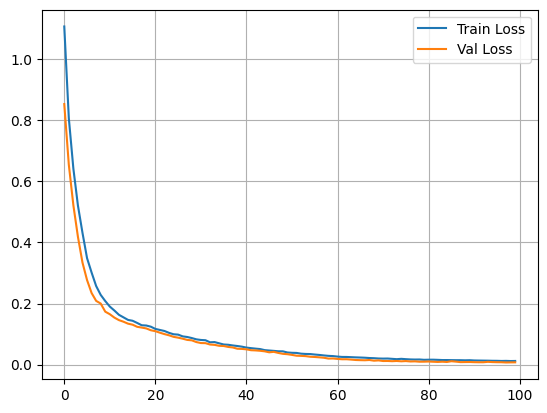

In [79]:
plt.figure()
plt.plot(losses, label = "Train Loss")
plt.plot(val_losses, label = "Val Loss")
plt.legend()
plt.grid(True)
plt.show()

## Plot latest 60 epochs

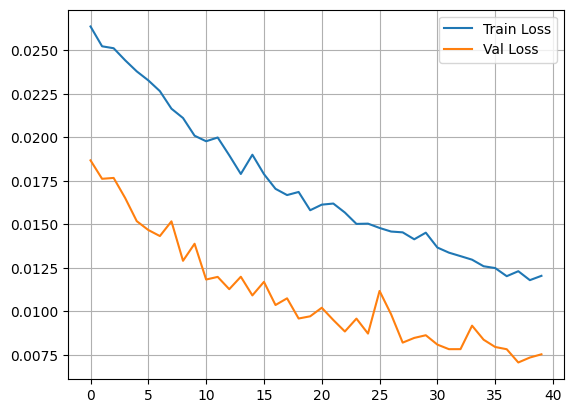

In [80]:
plt.figure()
plt.plot(losses[-40:], label = "Train Loss")
plt.plot(val_losses[-40:], label = "Val Loss")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
torch.save(model.state_dict(), "./trained_model_Attn.pt")

## Make predictions

In [81]:
X_batch, y_batch, Ybus_batch, attention = next(iter(test_loader))
X_batch = X_batch.to(torch.float)
y_batch = y_batch.to(torch.float)
attention = attention.to(torch.float)

y_pred = model(X_batch, Ybus_batch, attention)

loss = criterion(y_pred, y_batch)
print(loss.item())

# De-normalize
y_pred = y_pred*test_dataset.y_std + test_dataset.y_mean
y_batch = y_batch*test_dataset.y_std + test_dataset.y_mean

0.0067970119416713715


C:\Users\Eduardo Trabajo\AppData\Local\Temp\ipykernel_13996\957195010.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.X[index,:], self.y[index, :], torch.complex(torch.tensor(self.Ybuses_real[index,:]), torch.tensor(self.Ybuses_imag[index,:])), self.attention[index,:]


In [82]:
torch.concatenate([y_pred, y_batch], dim=1)

tensor([[1.0399, 0.2496, 1.0397, 0.2455],
        [1.0457, 0.2909, 1.0458, 0.2792],
        [1.0301, 0.6274, 1.0299, 0.6299],
        [1.0407, 0.2316, 1.0411, 0.2306],
        [1.0439, 0.1937, 1.0446, 0.1946],
        [1.0434, 0.1245, 1.0433, 0.1101],
        [1.0418, 0.1707, 1.0422, 0.1693],
        [1.0410, 0.1153, 1.0412, 0.1044],
        [1.0381, 0.1778, 1.0387, 0.1701],
        [1.0273, 0.5088, 1.0275, 0.4992],
        [1.0359, 0.1830, 1.0364, 0.1980],
        [1.0430, 0.2429, 1.0429, 0.2367],
        [1.0145, 0.4990, 1.0142, 0.5018],
        [1.0412, 0.2368, 1.0419, 0.2387],
        [1.0434, 0.1893, 1.0440, 0.1878],
        [1.0460, 0.3156, 1.0461, 0.3119],
        [1.0404, 0.1533, 1.0398, 0.1350],
        [1.0254, 0.5153, 1.0230, 0.5014],
        [1.0455, 0.2723, 1.0464, 0.2664],
        [1.0368, 0.1949, 1.0363, 0.1775],
        [1.0430, 0.1716, 1.0435, 0.1738],
        [1.0101, 0.6853, 1.0068, 0.7099],
        [1.0383, 0.1338, 1.0376, 0.1186],
        [1.0420, 0.1530, 1.0421, 0

In [83]:
y_pred[:,0]*230

tensor([239.1845, 240.5148, 236.9150, 239.3557, 240.0974, 239.9775, 239.6219,
        239.4312, 238.7663, 236.2679, 238.2458, 239.8931, 233.3318, 239.4812,
        239.9923, 240.5885, 239.2870, 235.8408, 240.4656, 238.4620, 239.8802,
        232.3333, 238.8051, 239.6547, 234.5152, 236.3737, 236.0814, 238.9919,
        236.2135, 240.6590, 239.2440, 239.6873], grad_fn=<MulBackward0>)

In [84]:
y_batch[:,0]*230

tensor([239.1342, 240.5446, 236.8735, 239.4469, 240.2610, 239.9495, 239.6965,
        239.4674, 238.9014, 236.3140, 238.3812, 239.8699, 233.2763, 239.6365,
        240.1085, 240.5930, 239.1545, 235.2819, 240.6797, 238.3505, 239.9969,
        231.5654, 238.6539, 239.6872, 234.4624, 236.3175, 235.8653, 238.9759,
        236.2185, 240.7267, 239.2840, 239.7231])

dataset = IEEE9Dataset()

torch.tensor([y_pred, y_batch])